# Import

In [35]:
!pip install fasttext
!pip install keras-core --upgrade
!pip install -q keras-nlp --upgrade

In [36]:
import zipfile
import pandas as pd
import re
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import fasttext

import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import tensorflow as tf
import keras_core as keras
import keras_nlp

from transformers import RobertaTokenizer

Loading data

In [ ]:
with zipfile.ZipFile('/content/drive/MyDrive/Courses/kaggle/NLP_with_disaster_tweets/input/nlp-getting-started.zip', 'r') as file:
  file.extractall('/content/drive/MyDrive/Courses/kaggle/NLP_with_disaster_tweets/input/')

In [37]:
data_train = pd.read_csv('/content/drive/MyDrive/Courses/kaggle/NLP_with_disaster_tweets/input/train.csv')
data_test = pd.read_csv('/content/drive/MyDrive/Courses/kaggle/NLP_with_disaster_tweets/input/test.csv')
data_all = pd.concat([data_train, data_test])

In [32]:
data_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Target distribution

<Axes: ylabel='target'>

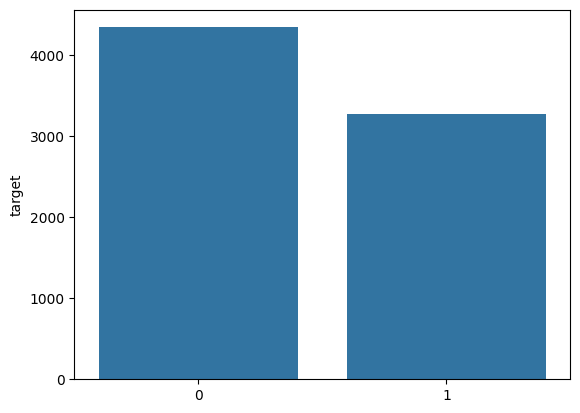

In [33]:
sns.barplot(data_train.target.value_counts())

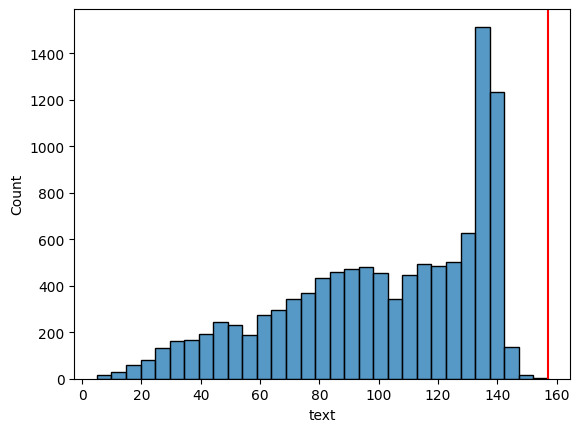

In [ ]:
sns.histplot(data_all.text.apply(len))
plt.axvline(data_all.text.apply(len).max(), c='red')
plt.show()

Clean data using RegEx

In [38]:
def text_cleaner(text_sample:str) -> str:
  """
    Remove unnecessary words and characters from the text for classification
  """
  text_sample = text_sample.strip()
  text_sample = re.sub(r'\s+', ' ', text_sample)  # convert into a single line
  text_sample = re.sub(r'\bhttps?://\S+/?\b', '', text_sample)  # remove links
  text_sample = re.sub(r'/', '', text_sample)
  text_sample = re.sub(r"[^\w\s'’—–]", '', text_sample)  # remove symbols
  text_sample = text_sample.lower()
  text_sample = re.sub(r" +", " ", text_sample)  # remove extra spaces
  text_sample = text_sample.strip()
  return text_sample

In [39]:
data_train['text'] = data_train['text'].apply(text_cleaner)
data_test['text'] = data_test['text'].apply(text_cleaner)

In [36]:
data_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,all residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1


Balance target classes

In [40]:
data_train[data_train.target == 1].shape[0]

3271

In [40]:
data_train_balanced = pd.concat([data_train[data_train.target == 0].sample(n=data_train[data_train.target == 1].shape[0]),
                                 data_train[data_train.target == 1]]).sample(frac=1)

In the sequel, we are going to use only the text and the keyword to classify the tweet. We create a new column 'target_text_keyword' of type str, and of the form '\_\_label__{class} {text} {keyword}', for example

'\_\_label__0 Kaggle is awsome for learning Data Science! Kaggle'

'\_\_label__1 The earthquake killed 200 person. damage'

We create a txt file such that each line in this file contains a tweet with the previous format. This format is requiried by fastText to train the model.

In [ ]:
data_train['target_text_keyword'] = '__label__' + data_train.target.astype(str) + ' ' + data_train.text + ' ' + data_train.keyword.apply(lambda x: x if x is not np.NaN else '')

In [ ]:
data_train.head()

,id,keyword,location,text,target,target_text_keyword
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1,__label__1 our deeds are the reason of this ea...
1,4,NaN,NaN,forest fire near la ronge sask canada,1,__label__1 forest fire near la ronge sask canada
2,5,NaN,NaN,all residents asked to 'shelter in place' are ...,1,__label__1 all residents asked to 'shelter in ...
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1,__label__1 13000 people receive wildfires evac...
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1,__label__1 just got sent this photo from ruby ...


Split and prepare data

In [ ]:
train, valid = train_test_split(data_train, test_size=0.2, random_state=123)

#create files for fastText
train.to_csv('/content/drive/MyDrive/Courses/kaggle/NLP_with_disaster_tweets/input/data_train.train', columns=['target_text_keyword'], index=False, header=False)
valid.to_csv('/content/drive/MyDrive/Courses/kaggle/NLP_with_disaster_tweets/input/data_train.test', columns=['target_text_keyword'], index=False, header=False)

# FastText

Training the model

In [ ]:
# Creating a training a model using fastText
model_ft = fasttext.train_supervised(input='/content/drive/MyDrive/Courses/kaggle/NLP_with_disaster_tweets/input/data_train.train')

# Performance of the model
model_ft.test('/content/drive/MyDrive/Courses/kaggle/NLP_with_disaster_tweets/input/data_train.test')

(1523, 0.8122127380170716, 0.8122127380170716)

In [ ]:
# Using the model to predict wether a tweet is a disaster or not
print(model_ft.predict("Kaggle is awsome for learning Data Science! Kaggle"))
print(model_ft.predict("The earthquake killed 200 person. damage"))

(('__label__0',), array([0.90088218]))
(('__label__1',), array([0.99759126]))


When model.predict is used, it returns a tuple, the first element is the most probable class of the tweet (this is useful when we have more than 3 classes), and the second is the probability of being in that class.

In [ ]:
print(model_ft.predict("Kaggle is awsome for learning Data Science! Kaggle",k=2))

(('__label__0', '__label__1'), array([0.90088218, 0.0991378 ]))


## FastText: Test Dataset

Prepare test dataset

In [ ]:
data_test['target_text_keyword'] = data_test.text + ' ' + data_test.keyword.apply(lambda x: x if x is not np.NaN else '')

In [ ]:
data_to_predict = data_test['target_text_keyword'].values.tolist()

In [ ]:
predictions = []

for sent in data_to_predict:
  if model_ft.predict(sent)[0][0] == '__label__0':
    predictions.append(0)  # it is not a disaster
  else:
    predictions.append(1)  # it is a disaster

In [ ]:
data_test['target_fastText'] = predictions

In [ ]:
data_test.head()

,id,keyword,location,text,target_text_keyword,target
0,0,NaN,NaN,just happened a terrible car crash,just happened a terrible car crash,1
1,2,NaN,NaN,heard about earthquake is different cities sta...,heard about earthquake is different cities sta...,0
2,3,NaN,NaN,there is a forest fire at spot pond geese are ...,there is a forest fire at spot pond geese are ...,1
3,9,NaN,NaN,apocalypse lighting spokane wildfires,apocalypse lighting spokane wildfires,0
4,11,NaN,NaN,typhoon soudelor kills 28 in china and taiwan,typhoon soudelor kills 28 in china and taiwan,1


# RoBERTa preproccessing

In [41]:
PRE_TRAINED_MODEL = 'roberta-base'

tokenizer = RobertaTokenizer.from_pretrained(PRE_TRAINED_MODEL)

In [61]:
def convert_to_bert_input_ids(raw_text):
  encode_plus = tokenizer.encode_plus(
      raw_text,
      add_special_tokens=True,
      max_length=157,  # max sequence length
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True
  )

  return encode_plus['input_ids'].flatten().tolist()

In [62]:
data_train_balanced['text_roberta'] = data_train_balanced['text'].apply(convert_to_bert_input_ids)

In [63]:
data_train_balanced.head()

,id,keyword,location,text,target,text_roberta
1319,1908,burning,LiÌ¬ge,rubi_ how many stacks of burning did it apply,0,"[0, 31413, 118, 1215, 141, 171, 32201, 9, 6574..."
5657,8069,rescue,NaN,suggs amp vivian to the rescue psychrewatch,0,"[0, 29, 15106, 29, 28127, 748, 1879, 811, 7, 5..."
4743,6746,lava,NaN,i wish that the earth sea and sky up above wou...,0,"[0, 118, 2813, 14, 5, 6872, 3342, 8, 6360, 62,..."
471,681,attack,Mumbai,india shud not give any evidence 2 pakthey wil...,1,"[0, 2028, 493, 1481, 1906, 45, 492, 143, 1283,..."
5320,7595,pandemonium,NaN,tube strike absolute pandemonium,0,"[0, 46389, 2506, 7833, 45235, 2, 1, 1, 1, 1, 1..."


In [75]:
new_train_df = data_train_balanced.text_roberta.apply(pd.Series)
new_train_df['target'] = data_train_balanced['target']
new_train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,148,149,150,151,152,153,154,155,156,target
1319,0,31413,118,1215,141,171,32201,9,6574,222,...,1,1,1,1,1,1,1,1,1,0
5657,0,29,15106,29,28127,748,1879,811,7,5,...,1,1,1,1,1,1,1,1,1,0
4743,0,118,2813,14,5,6872,3342,8,6360,62,...,1,1,1,1,1,1,1,1,1,0
471,0,2028,493,1481,1906,45,492,143,1283,132,...,1,1,1,1,1,1,1,1,1,1
5320,0,46389,2506,7833,45235,2,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0


# Bert (GPU)

Define variables for BERT

In [76]:
BATCH_SIZE = 64
NUM_TRAINING_EXAMPLES = data_train.shape[0]
TRAIN_SPLIT = 0.8
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 2
AUTO = tf.data.experimental.AUTOTUNE


In [78]:
x_train, x_valid, y_train, y_valid = train_test_split(new_train_df.drop('target', axis=1), new_train_df['target'], train_size=TRAIN_SPLIT, stratify=new_train_df['target'], random_state=123)
x_test = data_test['text']

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT.

The BertClassifier model can be configured with a preprocessor layer, in which case it will automatically apply preprocessing to raw inputs during fit(), predict(), and evaluate(). This is done by default when creating the model with from_preset().

We will choose DistilBERT model.that learns a distilled (approximate) version of BERT, retaining 97% performance but using only half the number of parameters (paper).

It has 40% less parameters than bert-base-uncased, runs 60% faster while preserving over 95% of BERT’s performances as measured on the GLUE language understanding benchmark.

Specifically, it doesn't have token-type embeddings, pooler and retains only half of the layers from Google's BERT.

In [79]:
# Load a DistilBERT model.
preset= "distil_bert_base_en_uncased"

# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,
                                                                   sequence_length=128,
                                                                   name="preprocessor_4_tweets"
                                                                  )

# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset,
                                                               preprocessor = preprocessor,
                                                               num_classes=2,  # change to 1
                                                               #activation='relu'
                                                               )

classifier.summary()

/usr/local/lib/python3.10/dist-packages/keras_nlp/src/models/backbone.py:37: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_nlp/src/models/backbone.py:37: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)        │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                  ┃ Output Shape                           ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)                     │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ token_ids (InputLayer)                        │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ distil_bert_backbone (DistilBertBackbone)     │ (None, None, 768)                      │      66,362,880 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ tf.__operators__.getitem_2 (SlicingOpLambda)  │ (None, 768)                            │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ pooled_dense (Dense)                          │ (None, 768)                            │         590,592 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ classifier_dropout (Dropout)                  │ (None, 768)                            │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ logits (Dense)                                │ (None, 2)                              │           1,538 │
└───────────────────────────────────────────────┴────────────────────────────────────────┴─────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

In [82]:
# Compile
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), #'BinaryCrossentropy',SparseCategoricalCrossentropy
    optimizer='rmsprop',
    metrics= ["accuracy"]
)

# Fit
history = classifier.fit(x=x_train,
                         y=y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS,
                         validation_data=(x_valid, y_valid)
                        )

ValueError: Dimensions 157 and 5233 are not compatible

In [13]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))

164/164 [==============================] - 27s 158ms/step


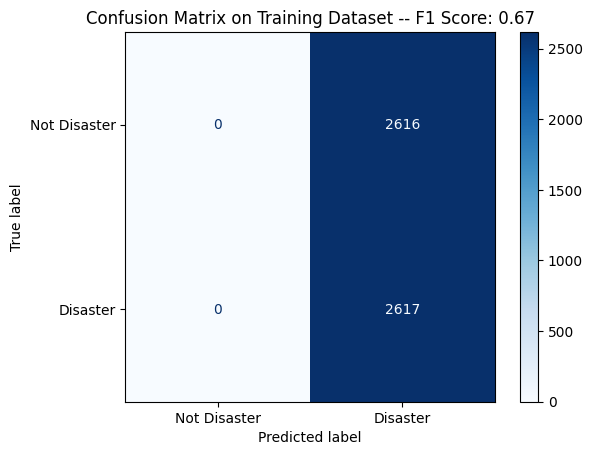

In [57]:
y_pred_train = classifier.predict(x_train)

displayConfusionMatrix(y_train, y_pred_train, "Training")

48/48 [==============================] - 10s 183ms/step


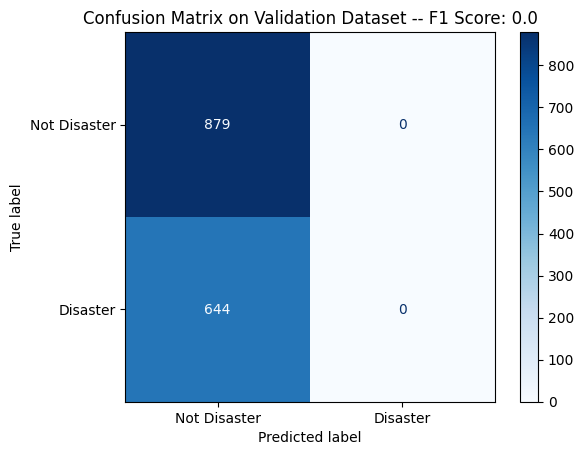

In [30]:
y_pred_val = classifier.predict(x_valid)

displayConfusionMatrix(y_valid, y_pred_val, "Validation")

## Bert: Test Dataset

In [ ]:
text = 'heard about earthquake is different cities stay safe everyone'
classifier.predict([text])

1/1 [==============================] - 1s 854ms/step


array([[ 0.0909024 , -0.11707623]], dtype=float32)

In [ ]:
data_test['target_Bert'] = np.argmax(classifier.predict(x_test), axis=1)

102/102 [==============================] - 22s 199ms/step


# Single layer LSTM

In [ ]:
# TBD

# Multi layer LSTM

In [ ]:
# TBD